In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/FinTech_VTB/Task_5"

In [3]:
%cd /content/drive/MyDrive/FinTech_VTB/Task_5

/content/drive/MyDrive/FinTech_VTB/Task_5


In [20]:
!kaggle competitions download -c benetech-making-graphs-accessible

 99% 971M/982M [00:16<00:00, 46.7MB/s]
100% 982M/982M [00:16<00:00, 63.5MB/s]


In [4]:
%cd /content

/content


In [7]:
%cp /content/drive/MyDrive/FinTech_VTB/Task_5/benetech-making-graphs-accessible.zip .

In [ ]:
!unzip benetech-making-graphs-accessible.zip

In [6]:
!git lfs install
!git clone https://huggingface.co/pszemraj/neuspell-subwordbert-probwordnoise
!pip install transformers
!pip install -U easyocr neuspell -q

Git LFS initialized.
Cloning into 'neuspell-subwordbert-probwordnoise'...
remote: Enumerating objects: 40, done.
remote: Total 40 (delta 0), reused 0 (delta 0), pack-reused 40
Unpacking objects: 100% (40/40), 5.36 KiB | 322.00 KiB/s, done.
Filtering content: 100% (3/3), 2.75 GiB | 35.76 MiB/s, done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 7.3 MB/s eta 0:00:00


In [8]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import easyocr
import os
import json
import cv2

from neuspell import BertChecker
from tqdm.autonotebook import tqdm as notebook_tqdm
from transformers import pipeline
from PIL import Image
from pathlib import Path

data folder is set to `/usr/local/lib/python3.10/dist-packages/neuspell/../data` script


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
annotations_dir = Path("train/annotations")

images_dir = Path("train/images")

annotations_count = len(list(annotations_dir.glob("*")))

images_count = len(list(images_dir.glob("*")))

print("Количество файлов в директории с аннотациями:", annotations_count)
print("Количество файлов в директории с изображениями:", images_count)

annotations_mapping = {}

for annotation_file in annotations_dir.glob("*.json"):
    filename = annotation_file.stem
    image = images_dir / (filename + ".jpg")
    annotations_mapping[filename] = {
        "image": image,
        "annotation": annotation_file
    }

Количество файлов в директории с аннотациями: 60578
Количество файлов в директории с изображениями: 60578


In [47]:
list(annotations_mapping.keys())[:10]

['63a17e134fd4',
 'a712982bc486',
 '14b7a21a71d6',
 'bc66bddb6af5',
 '0cbcf7bd95ab',
 '2a216e6c8a27',
 'd0b9fb989981',
 '3c3c40bbfe32',
 '15289b1d9726',
 '87616d4f30c0']

Текст на графике: ['Sex ratio by age (20 year olds) (UNWPP, 2017) in the year 1965', 'SEX RATIO', 'COUNTRY', '120', '100', '80', '60', '40', '20', '0', 'Moldova', 'Mongolia', 'Montenegro', 'More...', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia', 'Nepal', 'Netherlands']


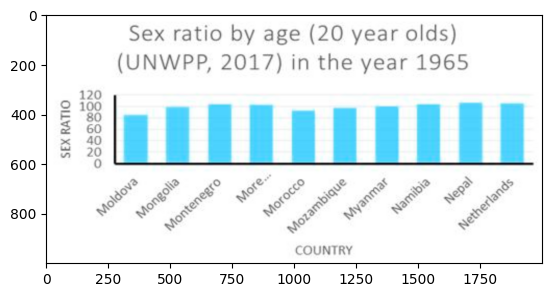

In [126]:
sample_image = cv2.imread(str(annotations_mapping["31f7151c4f0e"]["image"]))
with open(str(annotations_mapping["31f7151c4f0e"]["annotation"])) as f:
    sample_annotation = json.loads(f.read())

sample_image = cv2.resize(sample_image, (int(2000), int(1000)), interpolation = cv2.INTER_LINEAR)

plt.imshow(sample_image)

text_sample_images = [sample_annotation["text"][i]['text'] for i in range(len(sample_annotation["text"]))]

print(f"Текст на графике: {text_sample_images}")

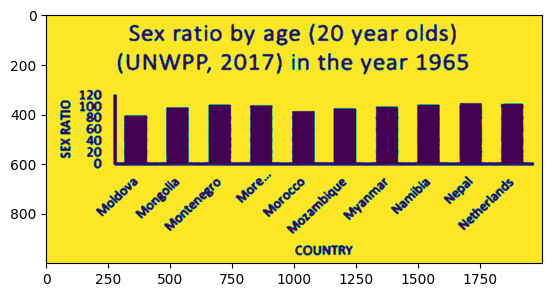

In [128]:
gray = cv2.cvtColor(sample_image, cv2.COLOR_BGR2GRAY)
denoised = cv2.medianBlur(gray, 3)
_, binary = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(binary)

In [129]:
cv2.imwrite("test.jpg", binary)

True

#### Попробуем применить OCR над примером выше

In [57]:
reader = easyocr.Reader(["en"])

In [67]:
result = reader.readtext(
    str("/content/test.jpg"),
    decoder="beamsearch",
    paragraph=False,
    detail=1,
    rotation_info=[30, 60, 90, 180],
)

In [68]:
print("Распознаный текст:")
for info in result:
    print(f"\t{info[1]}")

Распознаный текст:
	by
	age (20 vear olds)
	Sex ratio
	1
	120
	0
	100
	88
	28
	0
	More_
	0
	Namibia
	Moldova
	Morocco
	Mongolia
	Myanmar
	Netherlands
	Montenegro
	Mozambique
	COUNTRY


#### Попробуем применить neuspell над примером выше

In [15]:
!ls

benetech-making-graphs-accessible.zip  sample_data	      train
drive				       sample_submission.csv
neuspell-subwordbert-probwordnoise     test


In [16]:
checker = BertChecker()
try:
    checker.from_pretrained("./neuspell-subwordbert-probwordnoise/")
except RuntimeError as e:
    print("Игнорируем ошибку")

loading vocab from path:./neuspell-subwordbert-probwordnoise/vocab.pkl
initializing model


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

SubwordBert(
  (bert_dropout): Dropout(p=0.2, inplace=False)
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

In [69]:
before_spell_check = [info[1] for info in result]
print(f"До исправления: {before_spell_check}")

# Call che spell checker
after_spell_check = checker.correct_strings(before_spell_check)
print(f"После исправления: {after_spell_check}",)

До исправления: ['by', 'age (20 vear olds)', 'Sex ratio', '1', '120', '0', '100', '88', '28', '0', 'More_', '0', 'Namibia', 'Moldova', 'Morocco', 'Mongolia', 'Myanmar', 'Netherlands', 'Montenegro', 'Mozambique', 'COUNTRY']
После исправления: ['by', 'age ( 20 year olds )', 'Sex ratio', '1', '120', '0', '100', '88', '28', '0', 'More _', '0', 'Namibia', 'Moldova', 'Morocco', 'Mongolia', 'Myanmar', 'Netherlands', 'Montenegro', 'Mozambique', 'COUNTRY']


В итоге есть исправления на правильное, но также остался **Mont** и **Itenegro**.

### Построение pipeline (OCR + Spell Correction)

neuspell получилось применить даже с "костылями" при инициализации в классе все падает. На данном датасете все модели плохо работают с числами, дублируя их по несколько раз. В целом, можно написать правило, по которому это будет игнорироваться. Или дообучить на этом датасете, но тогда надо нагенерировать ошибок для обучения.  
Но встает вопрос, а как дообучаться на числах, если в слове понятно, что есть ошибка, а вот в числе по факту нет ошибок при написании его.

In [135]:
class OCRSpellCorr:
    def __init__(self):
        self.reader = easyocr.Reader(['en'])
        self.spell_check = BertChecker()
        try:
            self.spell_check.from_pretrained("./neuspell-subwordbert-probwordnoise/")
        except RuntimeError as e:
            print("Игнорируем ошибку")

    def preprocessing_image(self, image_path: str, output_path: str = "") -> str:
        image = cv2.imread(image_path)

        # Preprocessing
        image = cv2.resize(image, (int(2000), int(1000)), interpolation = cv2.INTER_LINEAR)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        denoised = cv2.medianBlur(gray, 3)
        _, binary = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        new_image = image_path.replace(".jpg", "_preprocessing.jpg")
        output_path += new_image
        cv2.imwrite(output_path, binary)

        return output_path

    def ocr(self, image_path: str) -> list[str]:
        ocr_result = self.reader.readtext(
            image_path,
            decoder="beamsearch",
            paragraph=False,
            detail=1,
            rotation_info=[30, 60, 90, 180]
        )

        return [detection[1] for detection in ocr_result]

    def spell_correction(self, texts: list[str]) -> list[str]:
        corrected_texts = self.spell_check.correct_strings(texts)

        return corrected_texts

    def pipeline(self, image_path: str) -> tuple[list[str], list[str]]:
        ocr_result = self.ocr(image_path)
        corrected_texts = self.spell_correction(ocr_result)

        return ocr_result, corrected_texts


def create_table(original_words: list[str], corrected_words: list[str]) -> pd.DataFrame:
    data = {"Распознанные слова": original_words, "Исправленные слова": corrected_words}
    df = pd.DataFrame(data)
    return df

def view_changes(verified_texts: dict[str, list[str]]) -> None:
    for name, verified_text in verified_texts.items():
        fig, ax = plt.subplots(figsize=(20, 6))

        image = cv2.imread(str(annotations_mapping[name]["image"]))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        original_words = verified_text[0]
        corrected_words = verified_text[1]
        df = create_table(original_words, corrected_words)

        print(f"{name:_^100}")
        plt.show()
        display(df)

In [100]:
ocr_spell_corr = OCRSpellCorr()

loading vocab from path:./neuspell-subwordbert-probwordnoise/vocab.pkl
initializing model
SubwordBert(
  (bert_dropout): Dropout(p=0.2, inplace=False)
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
     

In [130]:
check_names_images = list(np.random.choice(list(annotations_mapping.keys()), size=10, replace=False))

In [131]:
len(set(check_names_images))

10

Преобразование картинки не очень справляется с текстом, которые плохо читаем. + некоторые становятся хуже буквы.

In [137]:
verified_texts = {}

for names_images in check_names_images:
    # preprocess_image = ocr_spell_corr.preprocessing_image(str(annotations_mapping[names_images]["image"]))
    verified_texts[names_images] = ocr_spell_corr.pipeline(str(annotations_mapping[names_images]["image"]))

In [138]:
len(verified_texts)

10

____________________________________________3ae14c1804ef____________________________________________


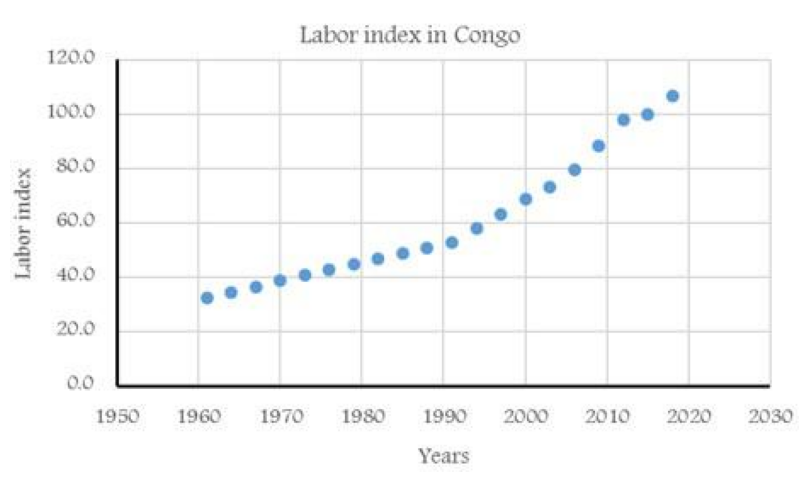

,Распознанные слова,Исправленные слова
0,Labr index in Congo,Labor index in Congo
1,1200,1200
2,0,0
3,0,0
4,0,0
5,8,8
6,0,0
7,40.0,40 . 0
8,8,8
9,0,0


____________________________________________d9a3d4cda8ce____________________________________________


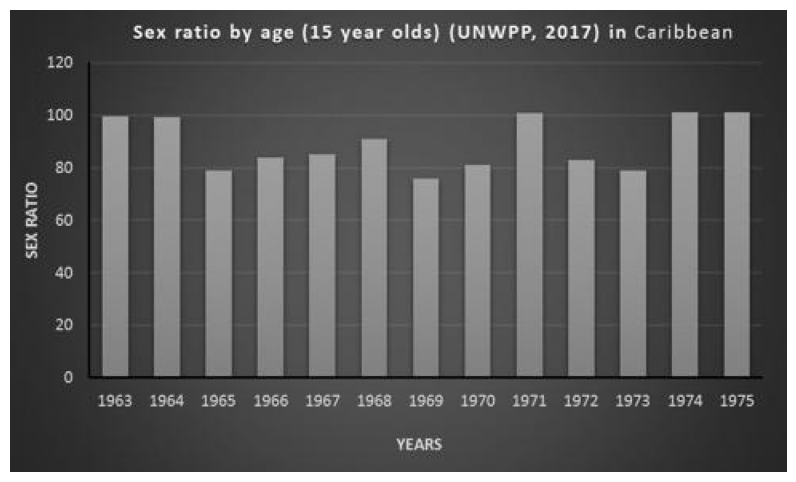

,Распознанные слова,Исправленные слова
0,Sex ratio by age (15 year olds) (UNWPP; 2017] ...,Sex ratio by age ( 15 year olds ) ( UNWPP ; 20...
1,8,8
2,8,8
3,1,1
4,1963,1963
5,1964,1964
6,1965,1965
7,1966,1966
8,1967,1967
9,3,3


____________________________________________27424ce36664____________________________________________


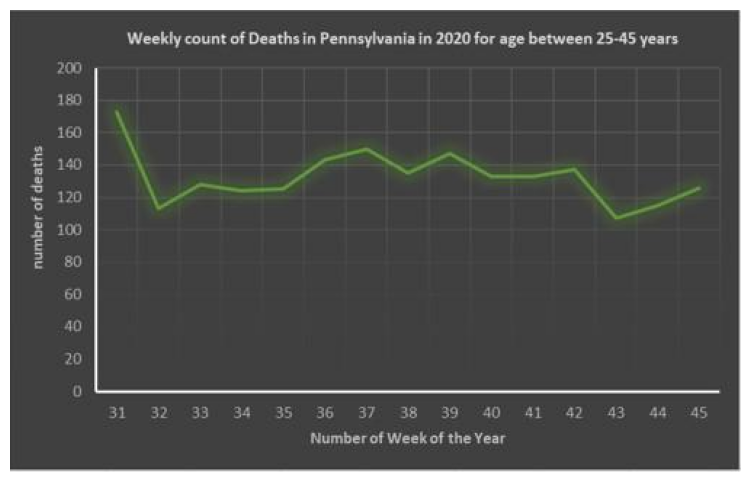

,Распознанные слова,Исправленные слова
0,Weekly count of Deaths in Pennsylvania in 2020...,Weekly count of Deaths in Pennsylvania in 2020...
1,8,8
2,180,180
3,8,8
4,1,1
5,140,140
6,8,8
7,8,8
8,47,47
9,37 38,37 38


____________________________________________c98c18ab6235____________________________________________


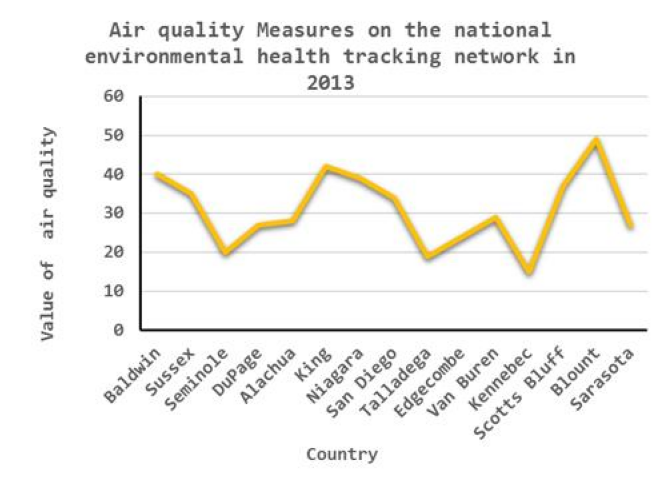

,Распознанные слова,Исправленные слова
0,Air quality,Air quality
1,on the,on the
2,Measures,Measures
3,national,national
4,tracking,tracking
5,environmental,environmental
6,1,1
7,network in,network for
8,2013,2013
9,0,0


____________________________________________ceabe914e5c0____________________________________________


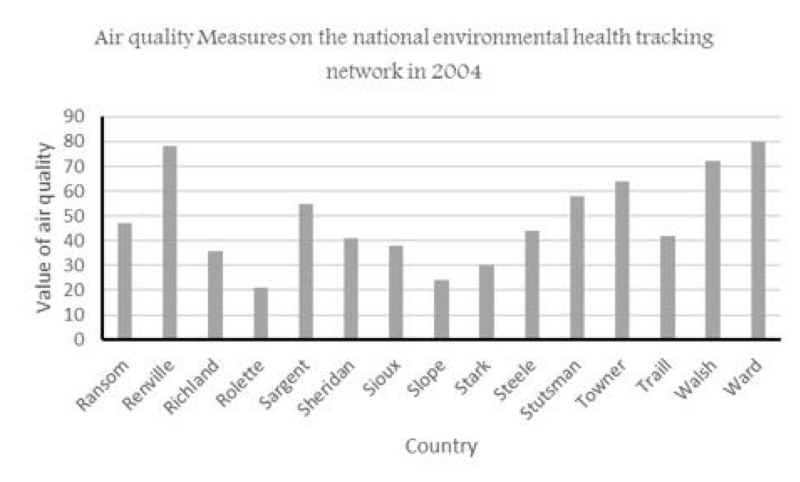

,Распознанные слова,Исправленные слова
0,L,L
1,1,1
2,1,1
3,30,30
4,0,0
5,Stark,Start
6,0,0
7,0,0
8,0,0
9,Ward,Ward


____________________________________________86e18f893fe9____________________________________________


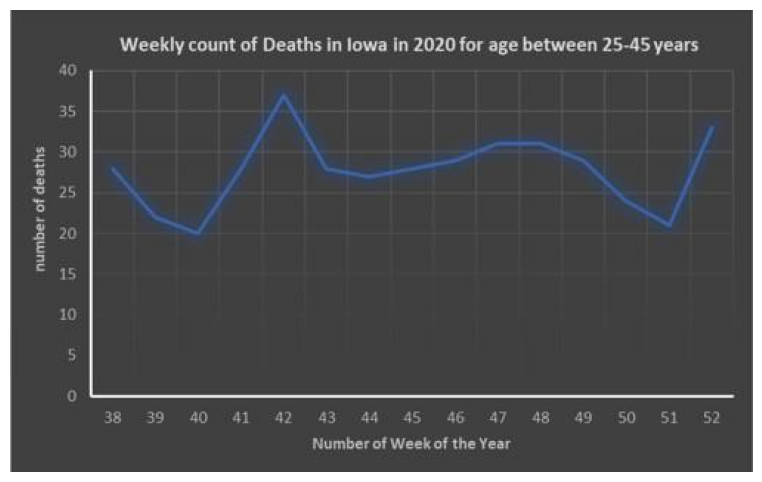

,Распознанные слова,Исправленные слова
0,Weekly count of Deaths in Iowa In 2020 for age...,Weekly count of Deaths in Iowa In 2020 for age...
1,1,1
2,1,1
3,1,1
4,44 45,44 45
5,9,9
6,47,47
7,1,1


____________________________________________af4fca7812f2____________________________________________


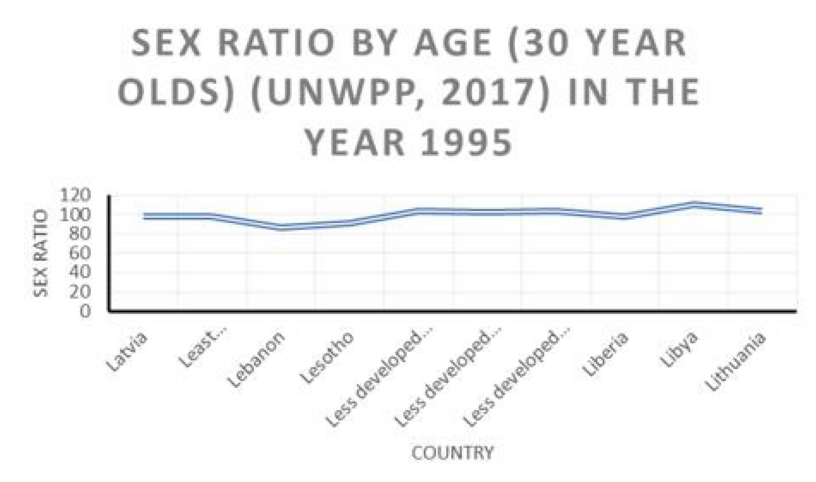

,Распознанные слова,Исправленные слова
0,SEX RATIO BY AGE (30 YEAR,SEX RATIO BY AGE ( 30 YEAR
1,"OLDS) (UNWPP, 2017) IN THE","OLDS ) ( UNWPP , 2017 ) IN THE"
2,YEAR 1995,YEAR 1995
3,8,8
4,8,8
5,1,1
6,89,89
7,Libya,Libya
8,],]
9,0,0


____________________________________________27ea2a1f36bd____________________________________________


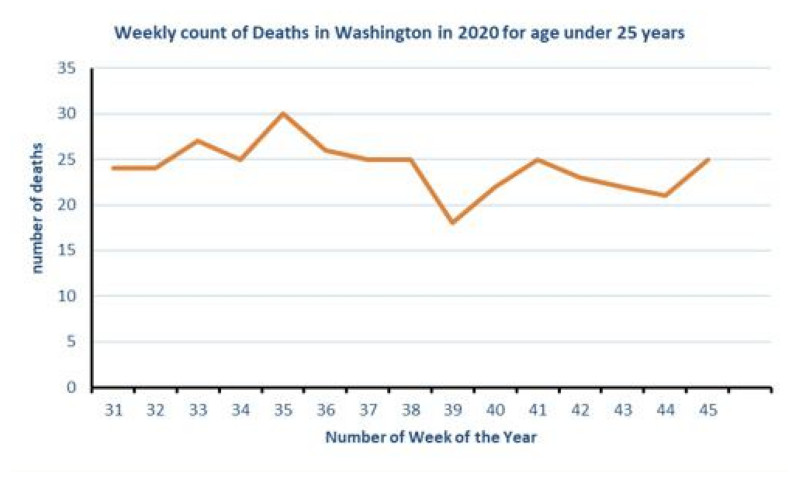

,Распознанные слова,Исправленные слова
0,Weekly count of Deaths in Washington In 2020 f...,Weekly count of Deaths in Washington In 2020 f...
1,[,[
2,0,0
3,Number of Weekof the Year,Number of Week the Year


____________________________________________ea8f2408e81a____________________________________________


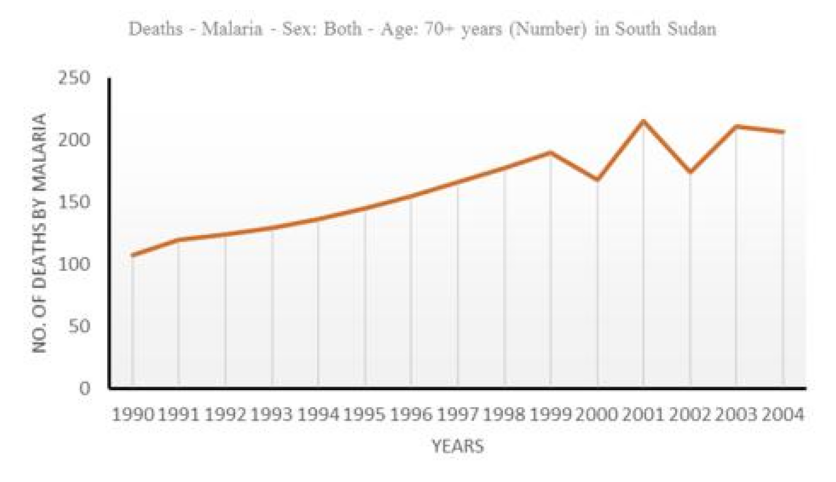

,Распознанные слова,Исправленные слова
0,Malaria,Malaria
1,8,8
2,Sex: Borh,Sex : Both
3,1,1
4,1,1
5,250,250
6,0,0
7,200,200
8,150,150
9,1,1


____________________________________________846d53a0624b____________________________________________


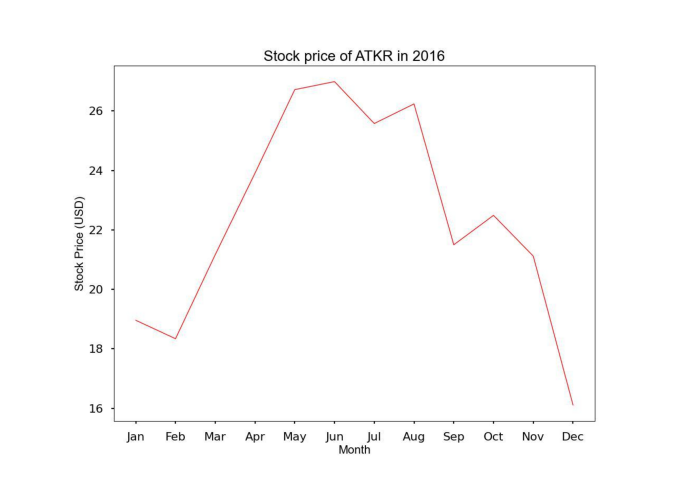

,Распознанные слова,Исправленные слова
0,Stock price of ATKR in 2016,Stock price of ATKR in 2016
1,26,26
2,24,24
3,(asn),( asn )
4,22,22
5,3,3
6,8,8
7,20,20
8,18,18
9,16,16


In [139]:
view_changes(verified_texts)